In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base_db = automap_base()

Base_db.prepare(engine, reflect=True)



# reflect the tables
station = Base_db.classes.station

In [6]:
# View all of the classes that automap found
all_classes = Base_db.classes

class_names = list(all_classes.keys())
for cls_name in class_names:
    print(f" {cls_name}")

 measurement
 station


In [7]:
# Save references to each table
table_references = {}

for table_name, table_class in all_classes.items():
    table_references[table_name] = table_class


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
measurement  = Base_db.classes.measurement 

most_recent_date = session.query(func.max(measurement.date)).scalar()

print( most_recent_date)

2017-08-23


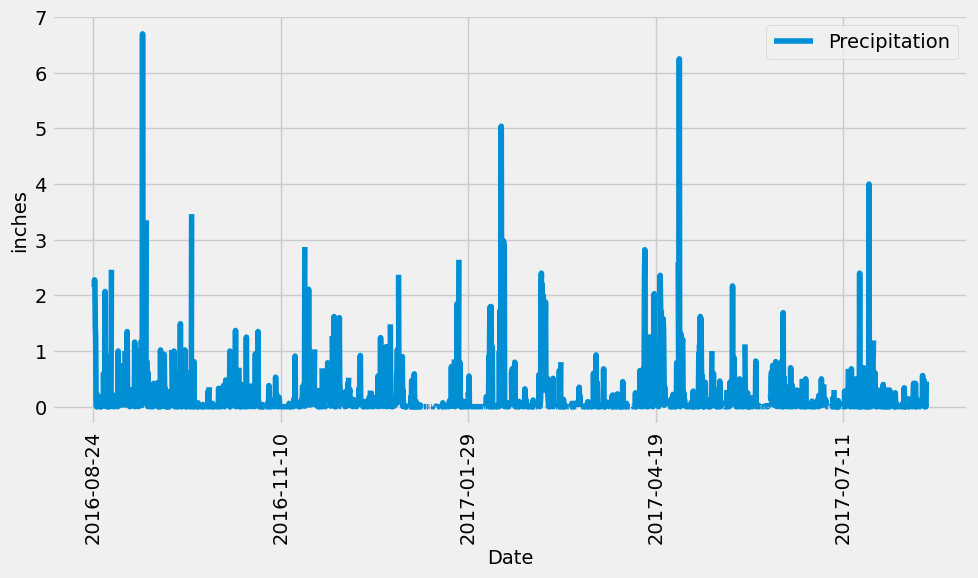

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

Measurement = Base_db.classes.measurement

most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
twelve_months_ago = most_recent_date - dt.timedelta(days=365)

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= twelve_months_ago).all()

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('inches')
plt.xticks(rotation=90)
plt.tight_layout()


plt.show()

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()

print(summary_stats.to_frame())

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
Station = Base_db.classes.station 

total_stations = session.query(Station).count()

result_format = [(total_stations,)]

print(result_format)

[(9,)]


In [47]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

Measurement = Base_db.classes.measurement

active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

formatted_result = [(station, count) for station, count in active_stations]

print(formatted_result)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


Measurement = Base_db.classes.measurement


active_station = session.query(Measurement.station) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()


most_active_station = active_station[0]


lowest_temp = session.query(func.min(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station) \
    .scalar()

highest_temp = session.query(func.max(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station) \
    .scalar()

average_temp = session.query(func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station) \
    .scalar()





result_format = [(lowest_temp, highest_temp, average_temp)]

print(result_format)

[(54.0, 85.0, 71.66378066378067)]


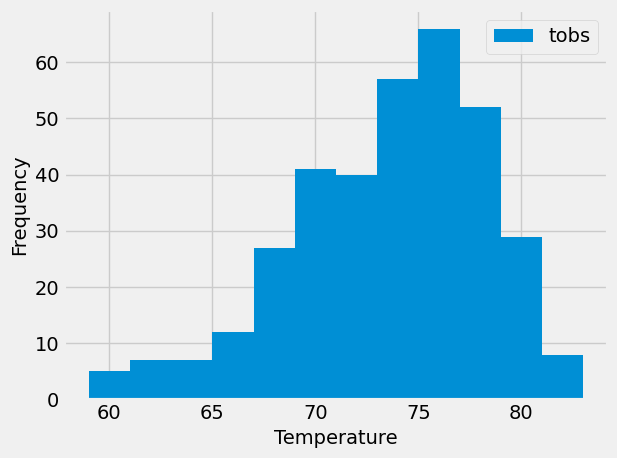

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


most_active_station = active_station[0]


most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)


tob_data = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= one_year_ago) \
    .all()



tob_values = [result[1] for result in tob_data]

plt.hist(tob_values, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()


plt.show()

# Close Session

In [16]:
# Close Session
session.close()